In [1]:
import mysql_auth 
from MySQLConnection import *
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from Modeling import *

In [2]:
# conn = MySQLConnection(DB_info=mysql_auth.NYXL_DB_Match_FinalStat)
# input_df = conn.read_all_tables_as_df()
input_df = pd.read_csv('input_df.csv')
display(input_df)

C:\Users\jyc13\anaconda3\envs\owl-data\lib\site-packages\IPython\core\interactiveshell.py:3166: DtypeWarning: Columns (6,42) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,MatchId,num_map,Map,map_type,Section,RoundName,Timestamp,Team,Player,...,OffensiveAssists/s,RCP,FBValue,DeathRisk,TF_order,TF_winner,TF_duration,TF_RCP_sum,TF_RCP_weighted_sum,DominanceIndex
0,0,37147,1,Busan,CONTROL,1.0,Sanctuary,2021-05-02 23:20:23,Dallas Fuel,Doha,...,0.0,-1.75,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.195832
1,1,37147,1,Busan,CONTROL,1.0,Sanctuary,2021-05-02 23:20:23,Dallas Fuel,Fielder,...,0.0,-1.75,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.195832
2,2,37147,1,Busan,CONTROL,1.0,Sanctuary,2021-05-02 23:20:23,Dallas Fuel,Jecse,...,0.0,-1.75,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.195832
3,3,37147,1,Busan,CONTROL,1.0,Sanctuary,2021-05-02 23:20:23,Houston Outlaws,Crimzo,...,0.0,-1.75,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.195832
4,4,37147,1,Busan,CONTROL,1.0,Sanctuary,2021-05-02 23:20:23,Houston Outlaws,Happy,...,0.0,-1.75,0.0,0.0,NaN,NaN,NaN,NaN,NaN,1.195832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2485317,2485317,37404,3,Eichenwalde,HYBRID,2.0,NaN,2021-06-06 19:59:43,Houston Outlaws,Dreamer,...,0.0,0.00,0.0,0.0,7.0,Dallas Fuel,66.927,34.833333,50.219882,-0.119838
2485318,2485318,37404,3,Eichenwalde,HYBRID,2.0,NaN,2021-06-06 19:59:43,Houston Outlaws,Happy,...,0.0,0.00,0.0,0.0,7.0,Dallas Fuel,66.927,34.833333,50.219882,-0.119838
2485319,2485319,37404,3,Eichenwalde,HYBRID,2.0,NaN,2021-06-06 19:59:43,Houston Outlaws,joobi,...,0.0,0.00,0.0,0.0,7.0,Dallas Fuel,66.927,34.833333,50.219882,-0.119838
2485320,2485320,37404,3,Eichenwalde,HYBRID,2.0,NaN,2021-06-06 19:59:43,Houston Outlaws,joobi,...,0.0,0.00,0.0,0.0,7.0,Dallas Fuel,66.927,34.833333,50.219882,-0.119838


In [3]:
# selected_features = [
#     'TimePlayed/s', 'HeroDamageDealt/s', 'BarrierDamageDealt/s', 'HeroDamageTaken/s', 'HealingDealt/s', 'HealingReceived/s', 'DefensiveAssists/s', 'OffensiveAssists/s', 'EnvironmentalDeaths/s', 'EnvironmentalKills/s', 'SoloKills/s', 'UltimatesUsed/s'
# ]
selected_features = ['TimePlayed/s', 'UltimatesUsed/s']

In [4]:
df_init = input_df[input_df['TF_order'].notna()]
df_init['IsTFWinner'] = df_init['Team'] == df_init['TF_winner'] # TF_winner
df_init['IsMapWinner'] = df_init['Team'] == df_init['MapWinner'] # Map_winner
target_flag = 'Teamfight' # Map or Teamfight

if target_flag == 'Map':
    grouping_index = ['MatchId', 'num_map', 'Map', 'Team']
    target = 'IsMapWinner'
elif target_flag == 'Teamfight':
    grouping_index = ['MatchId', 'num_map', 'Map', 'Section', 'TF_order', 'Team']
    target = 'IsTFWinner'

df_init['HeroComp'] = df_init['Hero']
df_init = pd.get_dummies(data=df_init, columns=['HeroComp'], prefix='Hero')
df_init = df_init[df_init['TimePlayed/s'] != 0]
df_X = df_init.groupby(grouping_index)[selected_features + [x for x in df_init.columns if x.startswith('Hero_')] + [target]].sum()
df_X.loc[df_X[target] != 0, target] = 1
hero_col = [x for x in df_X.columns if x.startswith('Hero_')]
for col in hero_col:
    df_X.loc[df_X[col] != 0, col] = 1

df_y = df_X[target]
df_X = df_X.drop(target, axis=1)

df_X_norm = df_X.groupby([x for x in grouping_index if x != 'Team']).apply(lambda x: x/x.sum()) # 팀 상대적으로 비교하기 위해 normalization
df_X_norm = df_X_norm.fillna(0)

display(df_X_norm)
display(df_y)

ipykernel_launcher:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
ipykernel_launcher:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


TimePlayed/s  \
MatchId num_map Map         Section TF_order Team                            
37147   1       Busan       1.0     1.0      Dallas Fuel          0.501547   
                                             Houston Outlaws      0.498453   
                                    2.0      Dallas Fuel          0.500000   
                                             Houston Outlaws      0.500000   
                                    3.0      Dallas Fuel          0.500000   
...                                                                    ...   
37404   3       Eichenwalde 2.0     5.0      Houston Outlaws      0.500000   
                                    6.0      Dallas Fuel          0.500000   
                                             Houston Outlaws      0.500000   
                                    7.0      Dallas Fuel          0.500000   
                                             Houston Outlaws      0.500000   

                                                              UltimatesUsed/s  \
MatchId num_map Map         Section TF_order Team                               
37147   1       Busan       1.0     1.0      Dallas Fuel             0.000000   
                                             Houston Outlaws         0.000000   
                                    2.0      Dallas Fuel             1.000000   
                                             Houston Outlaws         0.000000   
                                    3.0      Dallas Fuel             0.750000   
...                                                                       ...   
37404   3       Eichenwalde 2.0     5.0      Houston Outlaws         1.000000   
                                    6.0      Dallas Fuel             0.434783   
                                             Houston Outlaws         0.565217   
                                    7.0      Dallas Fuel             0.428571   
                                             Houston Outlaws         0.571429   

                                                              Hero_Ana  \
MatchId num_map Map         Section TF_order Team                        
37147   1       Busan       1.0     1.0      Dallas Fuel           0.0   
                                             Houston Outlaws       1.0   
                                    2.0      Dallas Fuel           0.0   
                                             Houston Outlaws       1.0   
                                    3.0      Dallas Fuel           0.0   
...                                                                ...   
37404   3       Eichenwalde 2.0     5.0      Houston Outlaws       0.0   
                                    6.0      Dallas Fuel           0.0   
                                             Houston Outlaws       0.0   
                                    7.0      Dallas Fuel           0.0   
                                             Houston Outlaws       0.0   

                                                              Hero_Ashe  \
MatchId num_map Map         Section TF_order Team                         
37147   1       Busan       1.0     1.0      Dallas Fuel            0.0   
                                             Houston Outlaws        0.0   
                                    2.0      Dallas Fuel            0.0   
                                             Houston Outlaws        0.0   
                                    3.0      Dallas Fuel            0.0   
...                                                                 ...   
37404   3       Eichenwalde 2.0     5.0      Houston Outlaws        0.0   
                                    6.0      Dallas Fuel            0.0   
                                             Houston Outlaws        0.0   
                                    7.0      Dallas Fuel            0.0   
                                             Houston Outlaws        0.0   

                                                      

MatchId  num_map  Map          Section  TF_order  Team           
37147    1        Busan        1.0      1.0       Dallas Fuel        1
                                                  Houston Outlaws    0
                                        2.0       Dallas Fuel        1
                                                  Houston Outlaws    0
                                        3.0       Dallas Fuel        1
                                                                    ..
37404    3        Eichenwalde  2.0      5.0       Houston Outlaws    1
                                        6.0       Dallas Fuel        1
                                                  Houston Outlaws    0
                                        7.0       Dallas Fuel        1
                                                  Houston Outlaws    0
Name: IsTFWinner, Length: 9094, dtype: int64

In [5]:
X = df_X_norm.values
y = df_y.values
feature_names = df_X_norm.columns 
# scaler = RobustScaler()
# X = scaler.fit_transform(X)
print(X.shape, y.shape)

(9094, 34) (9094,)


In [6]:
dnn = ModelDNN(X=X, y=y) 
dnn.create_model()

X_train shape :  (6092, 34)
y_train shape :  (6092,)
X_test shape :  (3002, 34)
y_test shape :  (3002,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                2240      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 6,465
Trainable params: 6,465
Non-trainable params: 0
_________________________________________________________________


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                2240      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 6,465
Trainable params: 6,465
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 O

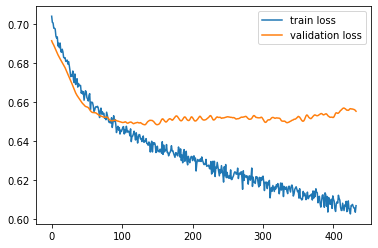

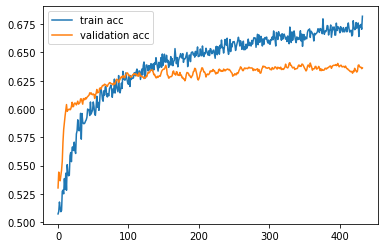

[0.6552378867643027, 0.6362425]

In [7]:
dnn.train_model(num_epoch=30000, batch_size=5000, patience=300, verbose=0)
dnn.model.evaluate(dnn.X_test, dnn.y_test, batch_size=3000, verbose=0)

## SHAP Interpretation

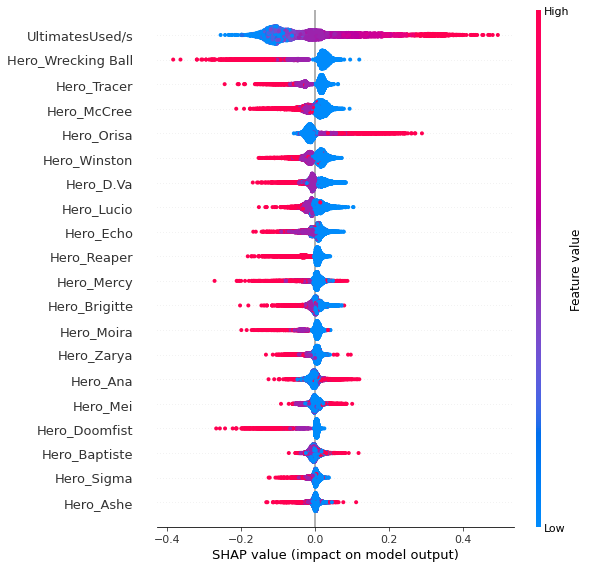

In [8]:
import shap

# load JS visualization code to notebook
shap.initjs()

# explain the model
explainer = shap.GradientExplainer(dnn.model, dnn.X_train)
shap_values = explainer.shap_values(dnn.X_train)

# plot
# shap.summary_plot(shap_values, dnn.X_test, feature_names=feature_names)
shap.summary_plot(shap_values[0], dnn.X_train, feature_names=feature_names)

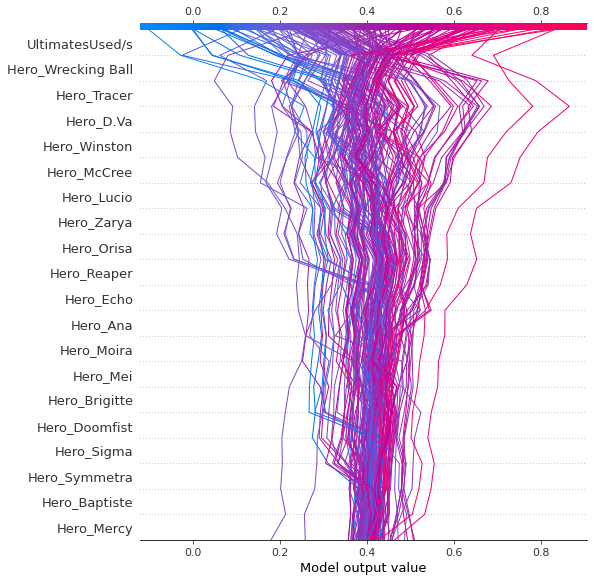

In [9]:
y_hat = dnn.model.predict(dnn.X_train[:150])
shap.decision_plot(y_hat[0], shap_values[0][:150], feature_names)

## 개별 항목 SHAP Explaination

In [10]:
df = df_X.reset_index()
df[df['Team'] == 'New York Excelsior']

,MatchId,num_map,Map,Section,TF_order,Team,TimePlayed/s,UltimatesUsed/s,Hero_Ana,Hero_Ashe,...,Hero_Soldier: 76,Hero_Sombra,Hero_Symmetra,Hero_Torbjorn,Hero_Tracer,Hero_Widowmaker,Hero_Winston,Hero_Wrecking Ball,Hero_Zarya,Hero_Zenyatta
3116,37241,1,Ilios,1.0,1.0,New York Excelsior,705.7544,4.0,1,0,...,0,0,0,0,0,0,0,1,0,0
3118,37241,1,Ilios,1.0,2.0,New York Excelsior,377.5652,6.0,1,0,...,0,0,0,0,1,0,0,1,0,0
3120,37241,1,Ilios,1.0,3.0,New York Excelsior,280.2600,3.0,1,0,...,0,0,0,0,1,0,0,1,0,0
3122,37241,1,Ilios,2.0,1.0,New York Excelsior,146.0193,0.0,0,1,...,0,0,0,0,0,0,0,1,0,0
3124,37241,1,Ilios,2.0,2.0,New York Excelsior,338.6674,0.0,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8831,37394,4,Dorado,1.0,2.0,New York Excelsior,175.1098,4.0,0,1,...,0,0,0,0,0,0,0,0,0,0
8833,37394,4,Dorado,1.0,3.0,New York Excelsior,300.7385,4.0,0,1,...,0,0,0,0,0,0,0,0,0,0
8835,37394,4,Dorado,1.0,4.0,New York Excelsior,236.5640,5.0,0,1,...,0,0,0,0,0,0,0,0,0,0
8837,37394,4,Dorado,2.0,1.0,New York Excelsior,379.4869,1.0,0,0,...,0,0,0,0,0,0,0,0,0,0


(37241, 1, 'Ilios', 1.0, 2.0, 'New York Excelsior') 0 vs  (37241, 1, 'Ilios', 1.0, 2.0, 'Shanghai Dragons') 1


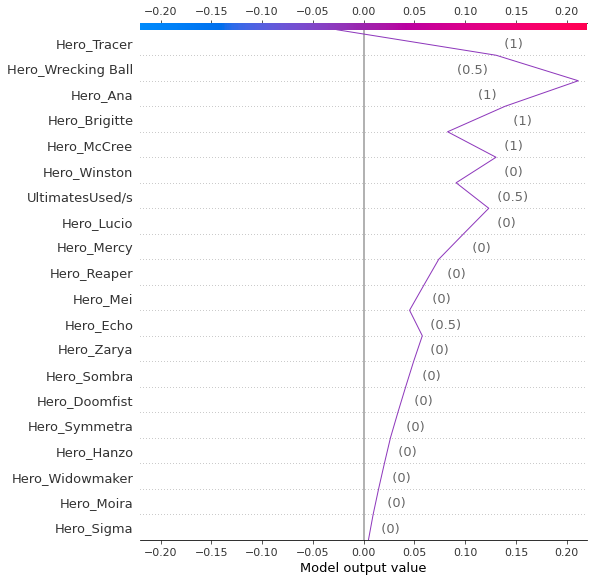

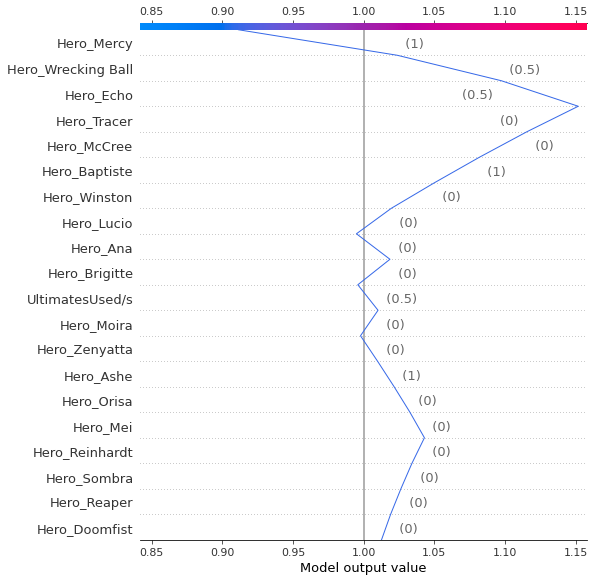

In [11]:
i = 3118
if i % 2 == 0: 
    j = i + 1
else: 
    j = i - 1

# inverse_X_train = scaler.inverse_transform(dnn.X_train)

print(df_X_norm.index[i], dnn.y_train[i], 'vs ', df_X_norm.index[j], dnn.y_train[j])
shap.decision_plot(dnn.y_train[i], shap_values[0][i], dnn.X_train[i], feature_names=feature_names.tolist())
shap.decision_plot(dnn.y_train[j], shap_values[0][j], dnn.X_train[j], feature_names=feature_names.tolist())